In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statannot
from bioinfokit import visuz
import gseapy as gp
from sklearn.preprocessing import StandardScaler
from gseapy import gseaplot
from scipy.stats import mannwhitneyu, zscore
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression
from sklearn.cluster import KMeans
from msresist.figures.common import subplotLabel, getSetup, import_phenotype_data, formatPhenotypesForModeling, plotDistanceToUpstreamKinase
from msresist.pre_processing import preprocessing
from msresist.clustering import DDMC
from msresist.plsr import plotStripActualVsPred, plotScoresLoadings

In [2]:
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [3]:
# MS = preprocessing(AXLwt_GF=True, Vfilter=True, FCtoUT=False, mc_col=True, mc_row=True)
# axl_e = MS[MS["Gene"] == "AXL"][["Position", "PC9", "Erl"]]
# axl_e.columns = ["AXL p-site", "PC9 UT", "PC9 +E"]
# axl_e = pd.melt(frame=axl_e, value_vars=["PC9 UT", "PC9 +E"], id_vars="AXL p-site", value_name="norm log(p-signal)", var_name="Condition")

# _, ax = plt.subplots(1, 1, figsize=(5, 4))
# sns.barplot(axl_e, x="AXL p-site", y="norm log(p-signal)", hue="Condition", ax=ax)

# from scipy.stats import ttest_rel

# a = axl_e.iloc[:5, -1].values
# b = axl_e.iloc[5:, -1].values
# _, pval = ttest_rel(a, b, axis=0)

# print("p-value =", pval)
# plt.savefig("erl.svg")

# from scipy.stats import ttest_rel

# a = axl_e.iloc[:5, -1].values
# b = axl_e.iloc[5:, -1].values
# ttest_rel(a, b, axis=0)

/home/marcc/AXLomics/msresist/figures/figure2.py:96: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  c_kmeans = x_.groupby("Cluster").mean().T


5


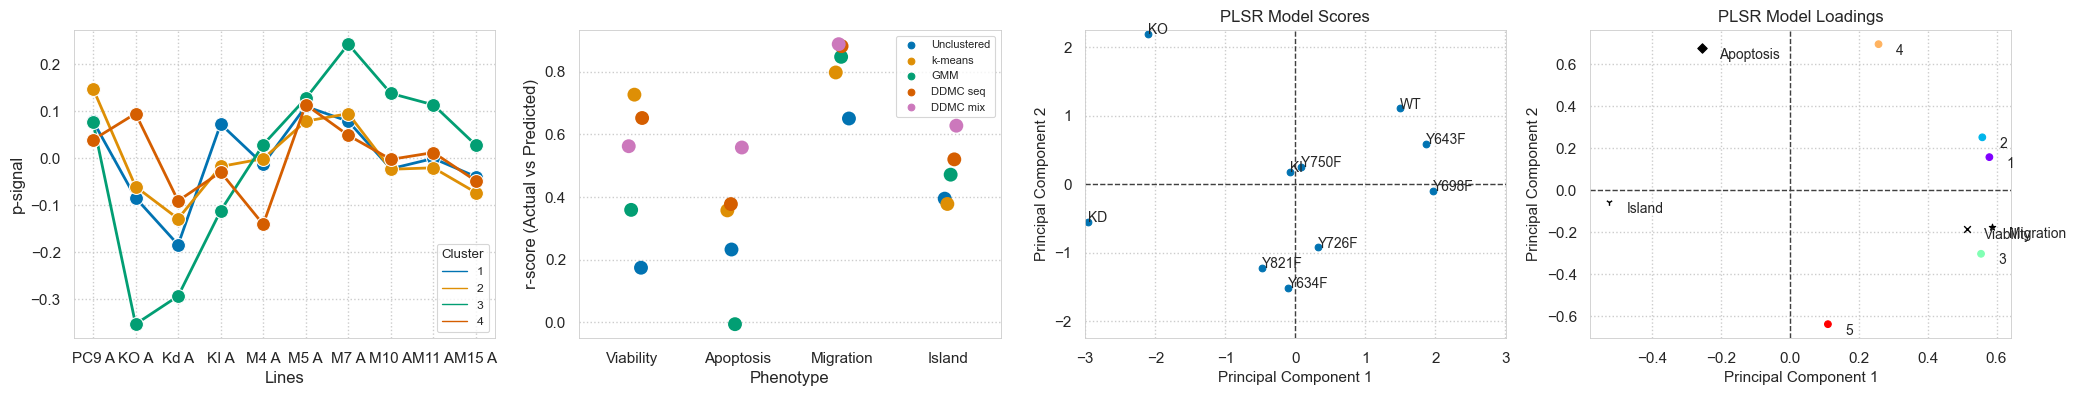

In [4]:
MS = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = MS.select_dtypes(include=['float64']).T
i = MS.select_dtypes(include=['object'])

# Fit DDMC
ddmc = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
centers = ddmc.transform()

# Import phenotypes
cv = import_phenotype_data(phenotype="Cell Viability")
red = import_phenotype_data(phenotype="Cell Death")
sw = import_phenotype_data(phenotype="Migration")
c = import_phenotype_data(phenotype="Island")
y = formatPhenotypesForModeling(cv, red, sw, c)
y = y[y["Treatment"] == "A/E"].drop("Treatment", axis=1).set_index("Lines")


from msresist.figures.figure2 import plotCenters_together, ComputeCenters
_, ax = plt.subplots(1, 4, figsize=(25, 4))
# Centers
plotCenters_together(ddmc, MS, ax[0], drop=5)

# Predictions
Xs, models = ComputeCenters(MS, d, i, ddmc)
Xs.append(centers)
print(len(Xs))
models.append("DDMC mix"),
plotStripActualVsPred(ax[1], [3, 4, 2, 3, 4], Xs, y, models)

# Scores & Loadings
lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
plsr = PLSRegression(n_components=4)
plotScoresLoadings(ax[2:4], plsr.fit(centers, y), centers, y, ddmc.n_components, lines, pcX=1, pcY=2)
# plt.savefig("centers.svg")

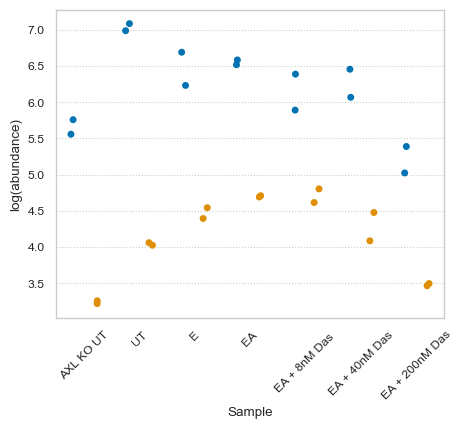

In [168]:
ad = pd.read_csv("/home/marcc/AXLomics/msresist/data/Validations/Luminex/102022-Luminex_AXL_Das.csv")
ad.iloc[:, 1:] = np.log(ad.iloc[:, 1:])
# ad.iloc[:, 1:] = pd.DataFrame(StandardScaler().fit_transform(ad.iloc[:, 1:]))
ad = pd.melt(ad, id_vars="Sample", value_vars=["tAXL", "pAXL"], var_name="t/p", value_name="log(abundance)")

_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.stripplot(ad, x="Sample", y="log(abundance)", hue="t/p", dodge=True, ax=ax)
sns.boxplot(ad, x="Sample", y="log(abundance)", hue="t/p", width=0.5, color="white", ax=ax)
ax.legend().remove()
plt.xticks(rotation=45);
plt.savefig("lumi_axl.svg")

In [5]:
# _, ax = plt.subplots(1, 1, figsize=(6, 5))
# plotDistanceToUpstreamKinase(ddmc, [1, 2, 3, 4], ax, num_hits=9)

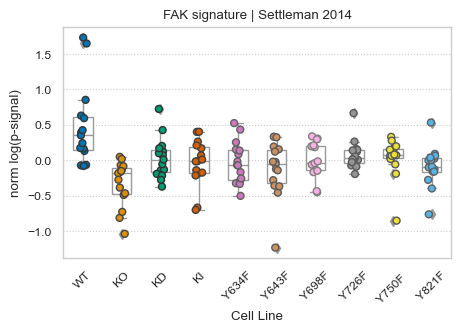

In [147]:
MS = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
MS.insert(0, "Phosphosite", [g + " " + p for g, p in zip(list(MS["Gene"]), list(MS["Position"]))])
MS.insert(0, "Cluster", ddmc.labels())
d = MS.set_index(["Cluster", "Gene", "Phosphosite"]).select_dtypes(include=[float])
d.columns = lines
d = d.reset_index()

fakS_phos = ["PTK2 Y570-p", "NEDD9 T185-p", "PEAK1 Y531-p", "CDK1 Y15-p", "AFAP1L2 S389-p", "PIK3R2 Y460-p;S457-p", "MYH9 Y9-p;Y11-p", "VCL Y692-p", "TNK2 Y859-p", "ACTN1 Y215-p", "BCAR3 Y212-p", "ABL1 Y185-p", "CNN3 Y261-p", "CAVIN1 Y308-p"]
# phos_fak = d.set_index("Phosphosite").loc[:, ["WT", "KO"]].loc[fakS_phos].reset_index()
# phos_fak.columns = ["Phosphosite", "PC9 WT", "PC9 AXL KO"]
phos_fak = d.set_index("Phosphosite").iloc[:, 2:].loc[fakS_phos].reset_index()
phos_fak = pd.melt(phos_fak, value_vars=list(phos_fak.columns[1:]), id_vars="Phosphosite", var_name="Cell Line", value_name="norm log(p-signal)")
phos_fak.iloc[phos_fak[phos_fak["Phosphosite"].str.contains("CDK1")].index, -1] *= -1

_, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.stripplot(phos_fak, x="Cell Line", y="norm log(p-signal)", dodge=False, linewidth=1, hue="Cell Line", ax=ax)
g = sns.boxplot(phos_fak, x="Cell Line", y="norm log(p-signal)", ax=ax, width=0.5, color="white").set_title("FAK signature | Settleman 2014")
ax.legend().remove()
plt.xticks(rotation=45);

# ax.set_ylim([-1.2, 2.5])
plt.savefig("FAK_allmutants.svg")

In [139]:
phos_fak.iloc[phos_fak[phos_fak["Phosphosite"].str.contains("CDK1")].index, -1] *= -1
phos_fak

,Phosphosite,Cell Line,norm log(p-signal)
0,PTK2 Y570-p,KD,-0.139589
1,NEDD9 T185-p,KD,0.124443
2,PEAK1 Y531-p,KD,-0.130740
3,CDK1 Y15-p,KD,0.070529
4,AFAP1L2 S389-p,KD,0.723332
...,...,...,...
115,ACTN1 Y215-p,Y821F,-0.128346
116,BCAR3 Y212-p,Y821F,-0.090530
117,ABL1 Y185-p,Y821F,0.003141
118,CNN3 Y261-p,Y821F,-0.160748


In [125]:
from scipy.stats import ttest_ind

a1 = phos_fak[phos_fak["Cell Line"] == "PC9 WT"].iloc[:, -1].values
a2 = phos_fak[phos_fak["Cell Line"] == "PC9 AXL KO"].iloc[:, -1].values

ttest_ind(a1, a2)

Ttest_indResult(statistic=4.792414929267829, pvalue=4.8920016303868e-05)

In [115]:
rna = pd.read_feather("/home/marcc/AXLomics/msresist/data/RNAseq/AXLrna/AXLmutants_RNAseq_merged.feather").iloc[:, 1:]
idsT = pd.read_csv("/home/marcc/AXLomics/msresist/data/RNAseq/AXLrna/transcripts_to_genes.csv")
ids = dict(zip(idsT["ENSEMBL1"], idsT["SYMBOL"]))
rna.insert(0, "Cell Lines", [s[:3] if "M1" in s else s[:2] for s in rna["Cell Line"]])
rna.insert(1, "Treatment", [s[-1] if s[-1] == "E" in s else s[-2:] for s in rna["Cell Line"]])
rna = rna.drop("Cell Line", axis=1)
rna.iloc[:, 2:] = np.log(rna.iloc[:, 2:] + 1)
# rna.iloc[:, 2:] = pd.DataFrame(StandardScaler().fit_transform(rna.iloc[:, 2:]))
rna.columns = ["Cell Lines", "Treatment"] + [ids[g] if g in ids.keys() else g for g in list(rna.columns[2:])]
rna.head()

,Cell Lines,Treatment,ENST00000631435.1,TRDD2,TRDD3,TRDD1,TRBD1,IGHD5OR15-5B,IGHD4OR15-4B,IGHD3OR15-3B,...,ENST00000638457.1,ENST00000638565.1,ENST00000640079.1,ENST00000638503.1,ENST00000640864.1,ENST00000639790.1,ENST00000639660.1,ENST00000643577.1,ENST00000646356.1,ENST00000645792.1
0,KD,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041047
1,KD,EA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167797
2,KD,UT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,KI,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058043
4,KI,EA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


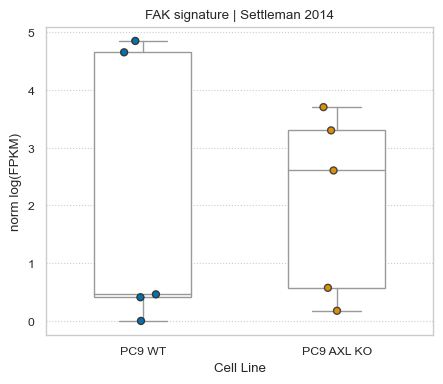

In [120]:
# fakS_rna = ['PTK2', 'NEDD9', 'PEAK1', 'CDK1','AFAP1L2','MAP1B','PIK3R2','CAVIN1','DOCK1','FYN','GIT2','MYH9','VCL','TNK2','ACTN1','BCAR3','PTPRE','ABL1','IL31RA','CNN3']
fakS_rna = ["AXL"]
rna_fak = rna[(rna["Treatment"] == "EA") | (rna["Treatment"] == "E") & (rna["Cell Lines"] == "KO")].set_index("Cell Lines").T[["WT", "KO"]].loc[fakS_rna].reset_index()
rna_fak.columns = ["Gene", "PC9 WT", "PC9 AXL KO"]
rna_fak = pd.melt(rna_fak, value_vars=["PC9 WT", "PC9 AXL KO"], id_vars="Gene", var_name="Cell Line", value_name="norm log(FPKM)")

_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.stripplot(rna_fak, x="Cell Line", y="norm log(FPKM)", dodge=False, linewidth=1, hue="Cell Line", ax=ax)
sns.boxplot(rna_fak, x="Cell Line", y="norm log(FPKM)", ax=ax, width=0.5, color="white").set_title("FAK signature | Settleman 2014")
ax.legend().remove()

## Heatmaps of specific p-sites

In [10]:
# d = d.loc[["GRB2 Y160-p", "GAB1 Y627-p", "CBLB Y889-p;T885-p", "SOS1 Y1196-p", "DAPP1 Y139-p", "EPS8 Y485-p"]]
# sns.clustermap(d, cmap="bwr", robust=True, figsize=(10, 3))

In [125]:
kin = [
    "EGFR Y1172-p",
    "EPHA2 Y594-p",
    "ERBB2 Y877-p",
    "ERBB3 Y1328-p",
    "MET S988-p",
    "GAB1 Y659-p",
    "GAB1 Y406-p",
    "GAB2 Y293-p",
    "GRB2 Y160-p",
    "SOS1 Y1196-p",
    "DAPP1 Y139-p",
    "CBLB Y363-p",
    "CBLB Y802-p;T798-p",
    "CBLB Y889-p;T885-p",
    "FLNA Y2379-p",
    "FLNB Y904-p",
    "AHNAK S115-p",
    "FRK Y132-p",
    "LYN Y397-p",
    "LCK Y192-p",
    "LCK Y394-p",
    "YES1 Y222-p",
    "YES1 S195-p",
    "ABL1 Y185-p",
    "ABI2 Y213-p",
    "MAPK1 Y187-p",
    "MAPK3 Y204-p",
    "MAPK9 Y185-p;T183-p",
    "MAPK10 Y223-p",
    "MAPK10 Y223-p;T221-p",
    "MAPK13 Y182-p",
    "MAPK14 Y182-p",
    "ICK S152-p",
    "ICK Y159-p",
    "PRKCD Y313-p",
    "CDK1 Y15-p",
    "CDK2 Y15-p",
    ]

/home/marcc/.local/lib/python3.9/site-packages/seaborn/matrix.py:1221: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


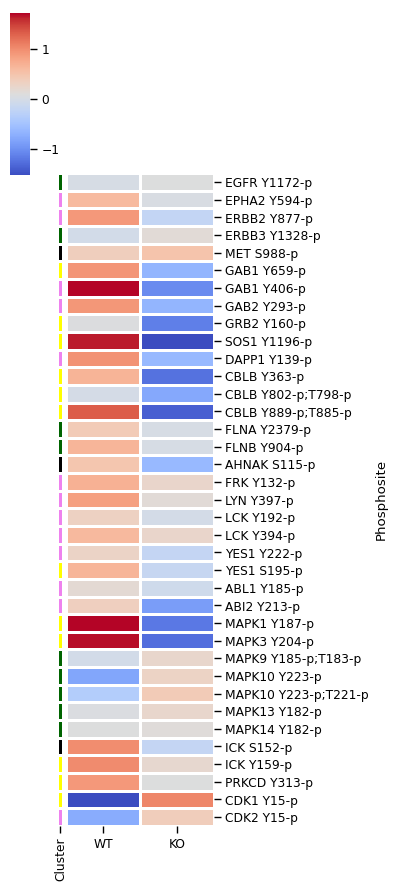

In [131]:
MS = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
MS.insert(0, "Phosphosite", [g + " " + p for g, p in zip(list(MS["Gene"]), list(MS["Position"]))])
MS.insert(0, "Cluster", ddmc.labels())
s_ea = MS.set_index("Phosphosite").loc[kin][["PC9 A", "KO A", "Cluster"]]
s_ea.columns = ["WT", "KO", "Cluster"]
clusters = s_ea.pop("Cluster")
lut = dict(zip(clusters.unique(), ["darkgreen", "violet", "black", "yellow"]))
row_colors = clusters.map(lut)
sns.clustermap(data=s_ea, cmap="coolwarm", row_cluster=False, col_cluster=False, row_colors=row_colors, linewidth=1, linecolor='w', square=True, robust=True, figsize=(4, 9))
plt.savefig("WTvsKO_selected.svg")

In [136]:
kin_gf = [
    "EGFR Y1197-p", 
    "EPHA2 Y594-p",
    "ERBB2 Y877-p",
    "MET S988-p",
    "GAB1 Y659-p",
    "GAB1 Y406-p",
    "GAB2 Y266-p",
    "FLNB Y904-p",
    "AHNAK Y836-p",
    "AHNAK Y715-p",
    "FRK Y132-p",
    "FRK Y497-p",
    "LYN Y193-p",
    "LCK Y192-p",
    "LCK Y394-p",
    "YES1 Y194-p",
    "ABL1 Y185-p",
    "ABI2 Y213-p",
    "MAPK1 Y187-p",
    "MAPK3 Y204-p",
    "MAPK9 Y185-p;T183-p",
    "MAPK10 Y223-p;T221-p",
    "MAPK13 T180-p",
    "MAPK14 Y182-p",
    "ICK Y159-p",
    "PRKCD Y374-p",
    "CDK1 Y15-p;T14-p",
]

/home/marcc/.local/lib/python3.9/site-packages/seaborn/matrix.py:1221: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


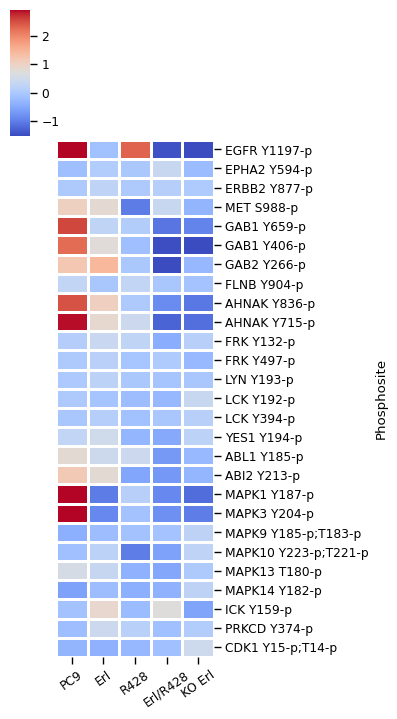

In [138]:
MSgf = preprocessing(AXLwt_GF=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
dgf = MSgf.select_dtypes(include=['float64']).T
MSgf.insert(0, "Phosphosite", [g + " " + p for g, p in zip(list(MSgf["Gene"]), list(MSgf["Position"]))])
s_gf = MSgf.set_index("Phosphosite").loc[kin_gf][["PC9", "Erl", "R428", "Erl/R428", "KO Erl"]]
cg = sns.clustermap(data=s_gf, cmap="coolwarm", row_cluster=False, col_cluster=False, linewidth=1, linecolor='w', square=True, robust=True, figsize=(4, 7))
plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=35)
plt.savefig("GF_selected.svg")

In [82]:

cl3 = MS[(MS["Cluster"] == 3)]

cl3_fc = pd.DataFrame()
cl3_fc["Gene"] = cl3["Gene"]
cl3_fc["log2(FC)"] = cl3["PC9 A"] - cl3["KO A"]
rnk = cl3_fc.sort_values(by="log2(FC)", ascending=False).set_index("Gene")

In [8]:
pre_res = gp.prerank(rnk=rnk,
                     gene_sets='WikiPathway_2021_Human',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir="/home/marcc/AXLomics/msresist/data/RNAseq/GSEA/Kurpa_gsea", # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2022-09-21 10:40:12,149 Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2022-09-21 10:40:12,154 Parsing data files for GSEA.............................
2022-09-21 10:40:12,155 Enrichr library gene sets already downloaded in: /home/marcc/.cache/gseapy, use local file
2022-09-21 10:40:12,162 0563 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-09-21 10:40:12,163 0059 gene_sets used for further statistical testing.....
2022-09-21 10:40:12,163 Start to run GSEA...Might take a while..................
2022-09-21 10:40:12,228 Start to generate gseapy reports, and produce figures...
2022-09-21 10:40:19,022 Congratulations. GSEApy runs successfully................



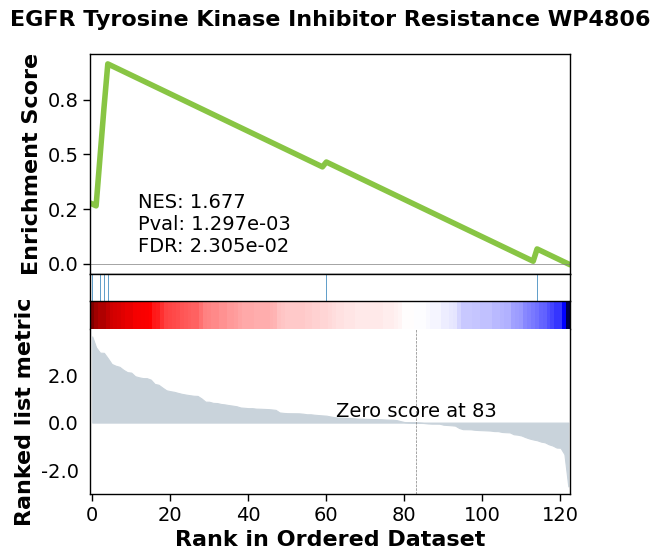

In [12]:
from gseapy import gseaplot
terms = pre_res.res2d.Term
i = 1
# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking,
         term="EGFR Tyrosine Kinase Inhibitor Resistance WP4806",
         **pre_res.results[terms[i]])